# Final Project Sketch :(


In [1]:
import pandas as pd
import numpy as np
import os
from math import sin, cos, sqrt, atan2, radians
import time
import matplotlib.pyplot as plt
import datetime


%matplotlib inline

pd.set_option('display.max_columns', 500)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="E:/GitHub/NYU-Taxi-project/My First Project-b3735f3b3a9d.json"
from google.cloud import bigquery
client = bigquery.Client()

## Query Data from BigQuery

In [ ]:
start = time.time()
query = (
"""
SELECT date_of_year, month_of_year, day_of_year, pickup_hour,
    dropoff_datetime,pickup_datetime,
    pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude, travel_time,
    temp, visib,mxpsd,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder
FROM
(
      SELECT *,ROW_NUMBER() OVER(partition by date_of_year, pickup_hour) as row_number
      FROM
      (
            SELECT pickup_datetime, dropoff_datetime, pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude,
            EXTRACT (HOUR FROM pickup_datetime) as pickup_hour,
            EXTRACT (DAY FROM pickup_datetime) as day_of_year,
            EXTRACT (MONTH FROM pickup_datetime) as month_of_year,
            EXTRACT (DATE FROM pickup_datetime) as date_of_year,
            TIMESTAMP_DIFF(TIMESTAMP(dropoff_datetime), TIMESTAMP(pickup_datetime), SECOND) as travel_time
            FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2016`
            WHERE pickup_latitude IS NOT NULL AND pickup_longitude IS NOT NULL and
                dropoff_longitude IS NOT NULL and dropoff_latitude IS NOT NULL
      ) x
) x
JOIN
(
 select cast(mo as int64) as month,cast(da as int64) as day,temp,visib,mxpsd,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder
 from `bigquery-public-data.noaa_gsod.gsod2016` where stn='725053'
) y on x.month_of_year = y.month and x.day_of_year = y.day
where x.row_number <= 200
"""
)
data=pd.io.gbq.read_gbq(query,dialect='standard')
end = time.time()
print("Time taken by above cell is {}.".format((end-start)/60))

In [3]:
data.head()

,date_of_year,month_of_year,day_of_year,pickup_hour,dropoff_datetime,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,travel_time,temp,visib,mxpsd,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder
0,2016-01-24,1,24,14,2016-01-24 15:00:00,2016-01-24 14:09:49,-73.981178,40.763863,-73.782532,40.644104,3011,26.7,7.4,17.1,6.3,26.0,35.1,19.9,1.82,5.9,1,0,1,0,0
1,2016-01-24,1,24,14,2016-01-24 14:46:18,2016-01-24 14:23:51,-74.001999,40.728172,-73.988266,40.759232,1347,26.7,7.4,17.1,6.3,26.0,35.1,19.9,1.82,5.9,1,0,1,0,0
2,2016-01-24,1,24,14,2016-01-24 14:05:28,2016-01-24 14:00:46,-73.977997,40.742031,-73.975990,40.751331,282,26.7,7.4,17.1,6.3,26.0,35.1,19.9,1.82,5.9,1,0,1,0,0
3,2016-01-24,1,24,14,2016-01-24 14:18:33,2016-01-24 14:06:42,-73.981468,40.778969,-73.959068,40.809368,711,26.7,7.4,17.1,6.3,26.0,35.1,19.9,1.82,5.9,1,0,1,0,0
4,2016-01-24,1,24,14,2016-01-24 14:18:29,2016-01-24 14:10:10,-74.016273,40.710487,-74.006577,40.732365,499,26.7,7.4,17.1,6.3,26.0,35.1,19.9,1.82,5.9,1,0,1,0,0


## Summary of Data

In [112]:
# Return high level information about data
data.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 871016 entries, 0 to 32116
Data columns (total 25 columns):
date_of_year         871016 non-null datetime64[ns]
month_of_year        871016 non-null int64
day_of_year          871016 non-null int64
pickup_hour          871016 non-null int64
dropoff_datetime     871016 non-null datetime64[ns]
pickup_datetime      871016 non-null datetime64[ns]
pickup_longitude     871016 non-null float64
pickup_latitude      871016 non-null float64
dropoff_longitude    871016 non-null float64
dropoff_latitude     871016 non-null float64
travel_time          871016 non-null int64
temp                 871016 non-null float64
visib                871016 non-null float64
mxpsd                871016 non-null object
wdsp                 871016 non-null object
gust                 871016 non-null float64
max                  871016 non-null float64
min                  871016 non-null float64
prcp                 871016 non-null float64
sndp                 871

## Create/Transform features

In [113]:
data["weekday"] = data['pickup_datetime'].dt.dayofweek

data['travel_time'] = round(data['travel_time']/60, 2)

# distiance_in_km
R = 6373.0

dlon = np.radians(data['dropoff_longitude']) - np.radians(data['pickup_longitude'])
dlat = np.radians(data['dropoff_latitude']) - np.radians(data['pickup_latitude'])

a = np.sin(dlat / 2)**2 + np.cos(data['pickup_latitude']) * np.cos(data['dropoff_latitude']) * np.sin(dlon / 2)**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

data['distance_in_km'] = round(R*c,3)

E:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


## Optimize the memory usage

In [114]:
# Create a function to be calculating memory usage
def get_usage(obj):
    if isinstance(obj, pd.DataFrame):
        usage = obj.memory_usage(deep=True).sum()
    else:
        usage = obj.memory_usage(deep=True)
    return "{:03.2f} MB".format(usage / (1024**2))

# Convert object to int
obj = data.select_dtypes(include = 'object')
obj_f32 = obj.apply(pd.to_numeric, downcast='unsigned')

# Convert int64 to int8
obj = data.select_dtypes(include = 'int64')
obj_int = obj.apply(pd.to_numeric, downcast='unsigned')

# Convert float64 to float32
obj = data.select_dtypes(include = 'float64')
obj_f = obj.apply(pd.to_numeric, downcast='float')

# Calculated the memory we reduced by down grade int and float
print("Original memory usage: ", get_usage(data))
data[obj_f32.columns] = obj_f32
data[obj_int.columns] = obj_int
data[obj_f.columns] = obj_f
print("After converting int and float memory usage: ", get_usage(data))

Original memory usage:  497.18 MB
After converting int and float memory usage:  90.54 MB


In [117]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 871016 entries, 0 to 32116
Data columns (total 27 columns):
date_of_year         871016 non-null datetime64[ns]
month_of_year        871016 non-null uint8
day_of_year          871016 non-null uint8
pickup_hour          871016 non-null uint8
dropoff_datetime     871016 non-null datetime64[ns]
pickup_datetime      871016 non-null datetime64[ns]
pickup_longitude     871016 non-null float32
pickup_latitude      871016 non-null float32
dropoff_longitude    871016 non-null float32
dropoff_latitude     871016 non-null float32
travel_time          871016 non-null float32
temp                 871016 non-null float32
visib                871016 non-null float32
mxpsd                871016 non-null float64
wdsp                 871016 non-null float64
gust                 871016 non-null float32
max                  871016 non-null float32
min                  871016 non-null float32
prcp                 871016 non-null float32
sndp                

## Process Missing Data & Outlier

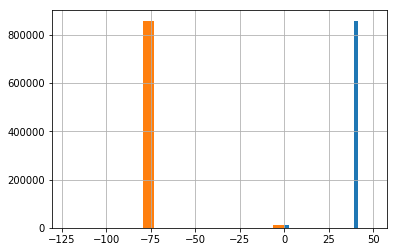

In [118]:
data['pickup_latitude'].hist(bins=20)
data['pickup_longitude'].hist(bins=20)

data = data[(data['pickup_longitude'] >= -79.7624) & (data['pickup_longitude'] <= -71.7517) &
                    (data['pickup_latitude'] >= 40.4772) & (data['pickup_latitude'] <= 45.0153)]

data = data[(data['dropoff_longitude'] >= -79.7624) & (data['dropoff_longitude'] <= -71.7517) &
                    (data['dropoff_latitude'] >= 40.4772) & (data['dropoff_latitude'] <= 45.0153)]

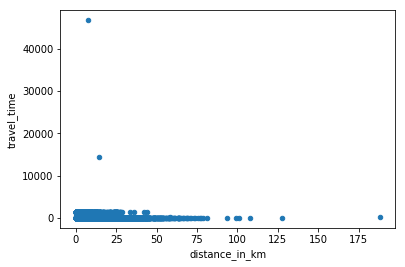

In [119]:
data.plot(x='distance_in_km',y='travel_time',kind='scatter')

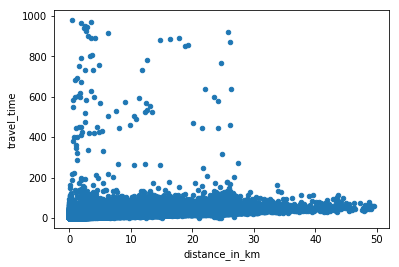

In [120]:
data = data[(data['travel_time']>0) & (data['distance_in_km']<50)  & (data['travel_time']<1000)]

data.plot(x='distance_in_km',y='travel_time',kind='scatter')

In [121]:
# refit visib 
for i in data.loc[(data['visib']== 999.9), 'date_of_year'].unique():
    data.loc[data['date_of_year'] == i,'visib'] =  data.loc[data['date_of_year'] == pd.to_datetime(i) - datetime.timedelta(1),'visib'].unique()

In [122]:
# refit mxpsd
for i in data.loc[(data['mxpsd']== 999.9), 'date_of_year'].unique():
    data.loc[data['date_of_year'] == i,'mxpsd'] =  data.loc[data['date_of_year'] == pd.to_datetime(i) - datetime.timedelta(1),'mxpsd'].unique()

In [140]:
# refit gust
for i in data.loc[(data['gust']== 999.9), 'date_of_year'].unique():
    data.loc[data['date_of_year'] == i,'gust'] =  data.loc[data['date_of_year'] == pd.to_datetime(i) - datetime.timedelta(1),'gust'].unique()

In [155]:
# refit sndp
data.loc[data['sndp'] == 999.9,'sndp'] =  0

In [156]:
data.loc[data['sndp']== 999.9, ['date_of_year','temp', 'visib', 'mxpsd', 'wdsp', 'gust', 'max', 'min',
       'prcp', 'sndp', 'fog', 'rain_drizzle', 'snow_ice_pellets', 'hail',
       'thunder', 'weekday']].drop_duplicates().head(20)

,date_of_year,temp,visib,mxpsd,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,weekday


In [158]:
data.loc[data['date_of_year'] == x[0]].drop_duplicates().head()

IndexError: index 0 is out of bounds for axis 0 with size 0

In [162]:
data[['date_of_year','temp', 'visib', 'mxpsd', 'wdsp', 'gust', 'max', 'min',
       'prcp', 'sndp', 'fog', 'rain_drizzle', 'snow_ice_pellets', 'hail',
       'thunder', 'weekday']].drop_duplicates().head(20)

,date_of_year,temp,visib,mxpsd,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,weekday
0,2016-01-24,26.700001,7.4,17.1,6.3,26.000000,35.099998,19.900000,1.82,5.9,1,0,1,0,0,6
809,2016-01-23,26.200001,1.7,20.0,12.8,36.900002,30.000000,21.000000,0.50,0.0,1,0,1,0,0,5
7181,2016-04-05,33.000000,10.0,13.0,7.9,24.100000,42.099998,26.100000,0.46,0.0,0,0,0,0,0,1
11981,2016-04-06,37.900002,10.0,14.0,4.9,24.100000,48.000000,26.100000,0.00,0.0,0,0,0,0,0,2
16781,2016-04-07,52.400002,9.3,11.1,5.8,22.900000,57.900002,30.000000,0.00,0.0,0,1,0,0,0,3
21581,2016-04-08,47.299999,10.0,11.1,6.7,25.100000,57.900002,42.099998,0.09,0.0,0,0,0,0,0,4
26381,2016-04-09,40.000000,9.1,8.9,4.9,15.900000,50.000000,36.000000,0.01,0.0,0,1,0,0,0,5
31181,2016-04-10,39.599998,10.0,8.0,4.4,17.100000,50.000000,30.900000,0.11,0.0,0,0,0,0,0,6
35981,2016-04-11,50.900002,9.3,9.9,5.6,18.100000,64.900002,30.900000,0.00,0.0,0,1,0,0,0,0
40781,2016-04-12,54.000000,9.1,8.9,5.3,22.000000,64.900002,43.000000,0.04,0.0,0,1,0,0,0,1


In [138]:
data.loc[data['date_of_year'] == x[0],'gust'] = 999.9

In [139]:
data.loc[data['date_of_year'] == x[0],'gust']

20659    999.900024
20660    999.900024
20661    999.900024
20662    999.900024
20663    999.900024
20664    999.900024
20665    999.900024
20666    999.900024
20667    999.900024
20668    999.900024
20669    999.900024
20670    999.900024
20671    999.900024
20672    999.900024
20673    999.900024
20674    999.900024
20675    999.900024
20676    999.900024
20677    999.900024
20678    999.900024
20679    999.900024
20680    999.900024
20681    999.900024
20682    999.900024
20683    999.900024
20684    999.900024
20685    999.900024
20686    999.900024
20687    999.900024
20688    999.900024
            ...    
25428    999.900024
25429    999.900024
25430    999.900024
25431    999.900024
25432    999.900024
25433    999.900024
25434    999.900024
25435    999.900024
25436    999.900024
25437    999.900024
25438    999.900024
25439    999.900024
25440    999.900024
25441    999.900024
25442    999.900024
25443    999.900024
25445    999.900024
25446    999.900024
25447    999.900024


## Optimize the memory usage

In [101]:
# Create a function to be calculating memory usage
def get_usage(obj):
    if isinstance(obj, pd.DataFrame):
        usage = obj.memory_usage(deep=True).sum()
    else:
        usage = obj.memory_usage(deep=True)
    return "{:03.2f} MB".format(usage / (1024**2))

# Convert object to int
obj = data.select_dtypes(include = 'object')
obj_f32 = obj.apply(pd.to_numeric, downcast='unsigned')

# Convert int64 to int8
obj = data.select_dtypes(include = 'int64')
obj_int = obj.apply(pd.to_numeric, downcast='unsigned')

# Convert float64 to float32
obj = data.select_dtypes(include = 'float64')
obj_f = obj.apply(pd.to_numeric, downcast='float')

# Calculated the memory we reduced by down grade int and float
print("Original memory usage: ", get_usage(data))
data[obj_f32.columns] = obj_f32
data[obj_int.columns] = obj_int
data[obj_f.columns] = obj_f
print("After converting int and float memory usage: ", get_usage(data))

Original memory usage:  108.93 MB
After converting int and float memory usage:  102.40 MB


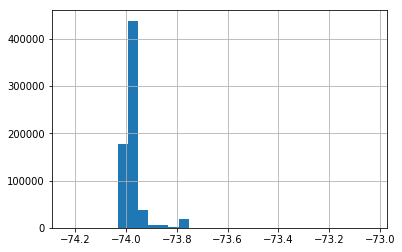

In [35]:
data_opt['pickup_longitude'].hist(bins=30)

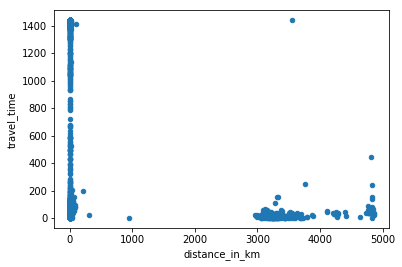

In [36]:
data_opt = data_opt[(data_opt['travel_time']>0) & (data_opt['distance_in_km']<5000)  & (data_opt['travel_time']<20000)]
data_opt.plot(x='distance_in_km',y='travel_time',kind='scatter')

In [16]:
data_opt.head(5)

,date_of_year,month_of_year,day_of_year,pickup_hour,dropoff_datetime,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,travel_time,temp,visib,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,distance_in_km
0,2016-01-01,1,1,11,2016-01-01 11:10:51,2016-01-01 11:03:50,-73.968033,40.759506,-73.986877,40.735752,7,40.400002,10.0,6.5,22.9,48.0,37.0,0.03,999.900024,0,0,0,0,0,2.523361
1,2016-01-01,1,1,11,2016-01-01 12:10:58,2016-01-01 11:57:46,-73.997055,40.722179,-73.977394,40.758743,13,40.400002,10.0,6.5,22.9,48.0,37.0,0.03,999.900024,0,0,0,0,0,3.967209
2,2016-01-01,1,1,11,2016-01-01 11:35:34,2016-01-01 11:26:49,-73.983940,40.775303,-73.975273,40.759426,8,40.400002,10.0,6.5,22.9,48.0,37.0,0.03,999.900024,0,0,0,0,0,1.724558
4,2016-01-01,1,1,11,2016-01-01 11:33:30,2016-01-01 11:31:48,-73.967598,40.755981,-73.976486,40.743851,1,40.400002,10.0,6.5,22.9,48.0,37.0,0.03,999.900024,0,0,0,0,0,1.297900
6,2016-01-01,1,1,11,2016-01-01 12:26:39,2016-01-01 11:57:15,-73.781906,40.644878,-73.956482,40.763008,29,40.400002,10.0,6.5,22.9,48.0,37.0,0.03,999.900024,0,0,0,0,0,13.765106


In [17]:
data.head(5)

,date_of_year,month_of_year,day_of_year,pickup_hour,dropoff_datetime,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,travel_time,temp,visib,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,distance_in_km
0,2016-01-01,1,1,11,2016-01-01 11:10:51,2016-01-01 11:03:50,-73.968033,40.759506,-73.986877,40.735752,7,40.4,10.0,6.5,22.9,48.0,37.0,0.03,999.9,0,0,0,0,0,2.523361
1,2016-01-01,1,1,11,2016-01-01 12:10:58,2016-01-01 11:57:46,-73.997055,40.722179,-73.977394,40.758743,13,40.4,10.0,6.5,22.9,48.0,37.0,0.03,999.9,0,0,0,0,0,3.967209
2,2016-01-01,1,1,11,2016-01-01 11:35:34,2016-01-01 11:26:49,-73.983940,40.775303,-73.975273,40.759426,8,40.4,10.0,6.5,22.9,48.0,37.0,0.03,999.9,0,0,0,0,0,1.724558
3,2016-01-01,1,1,11,2016-01-01 11:33:35,2016-01-01 11:30:19,0.000000,0.000000,0.000000,0.000000,3,40.4,10.0,6.5,22.9,48.0,37.0,0.03,999.9,0,0,0,0,0,0.000000
4,2016-01-01,1,1,11,2016-01-01 11:33:30,2016-01-01 11:31:48,-73.967598,40.755981,-73.976486,40.743851,1,40.4,10.0,6.5,22.9,48.0,37.0,0.03,999.9,0,0,0,0,0,1.297900


## EDA

In [67]:
%matplotlib inline
start = time.time()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 1, figsize=(11, 7), sharex=True)
sns.despine(left=True)
sns.distplot(np.log(train_df['trip_duration'].values+1), axlabel = 'Log(trip_duration)', label = 'log(trip_duration)', bins = 50, color="r")
plt.setp(axes, yticks=[])
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}.".format((end-start)))
plt.show()

NameError: name 'time' is not defined

In [54]:
sum(np.isnan(data['distance_in_km'] ))

159312

In [80]:
system.time()

NameError: name 'system' is not defined

In [79]:
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
plotly.tools.set_credentials_file(username='zxf71699', api_key='BkltlyEFcOkOAgCSdkjt')